1. **Data Preprocessing**
   - Data loading and preprocessing (e.g., normalization, resizing, augmentation).
   - Create visualizations of some images, and labels.

In [1]:
# 1. Data Preprocessing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout

# Cargar CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [2]:
!pip install GPUtil

In [3]:
# Configuración de logging
import logging
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Función de monitoreo de recursos
import psutil
import GPUtil

def monitor_resources():
    cpu_percent = psutil.cpu_percent()
    ram_percent = psutil.virtual_memory().percent
    try:
        gpu = GPUtil.getGPUs()[0]
        gpu_percent = gpu.memoryUtil * 100
        gpu_info = f"GPU Memory Usage: {gpu_percent:.2f}%"
    except:
        gpu_info = "GPU no disponible"
    
    logging.info(f"CPU Usage: {cpu_percent}%")
    logging.info(f"RAM Usage: {ram_percent}%")
    logging.info(gpu_info)
    
    return cpu_percent, ram_percent

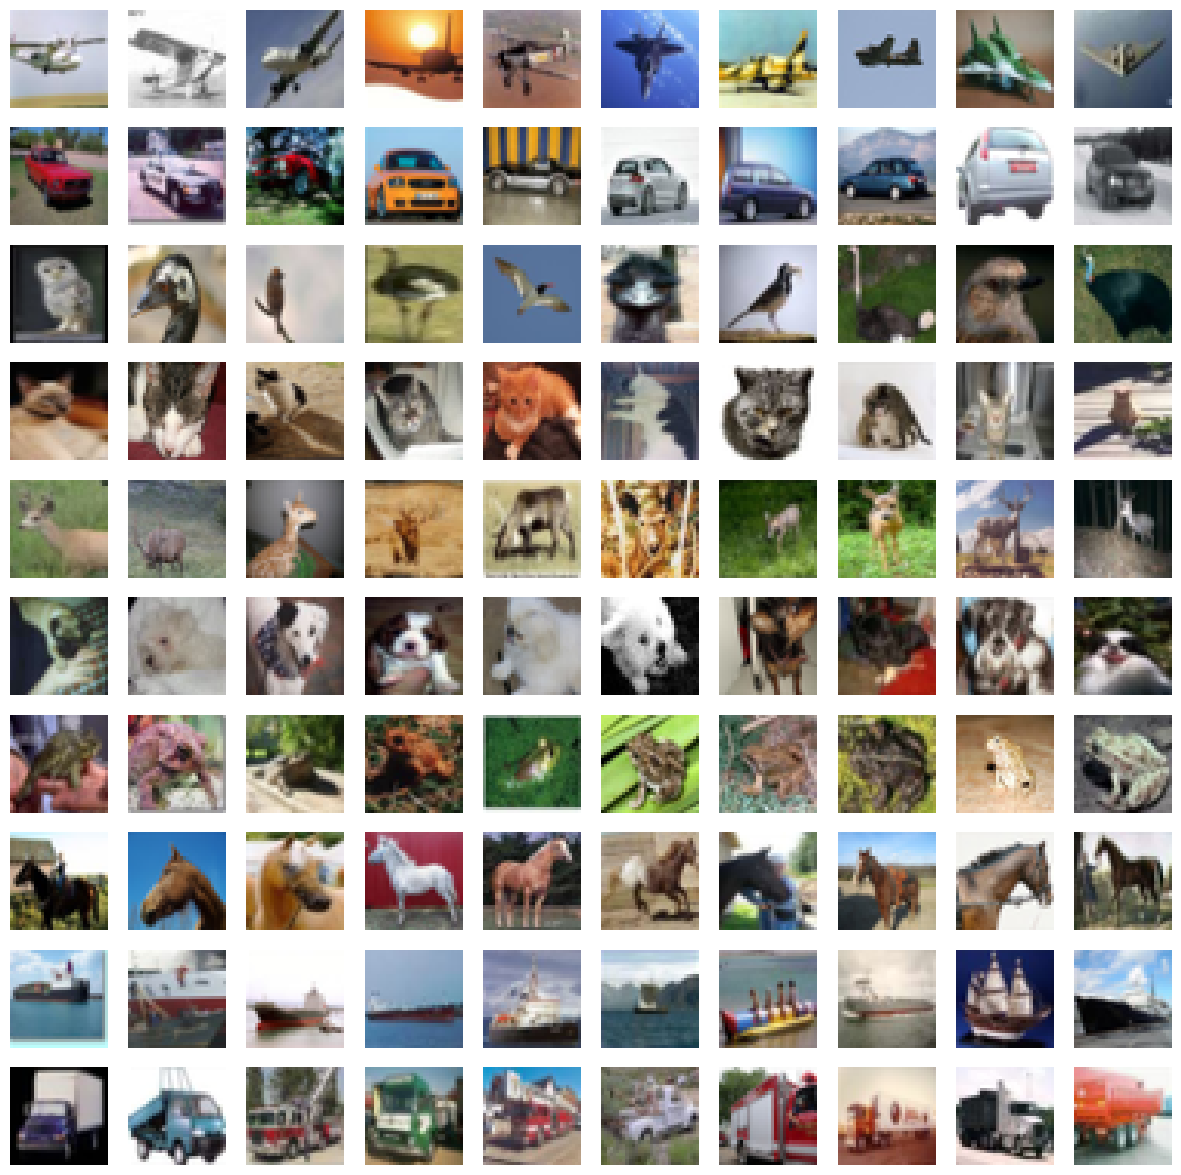

In [4]:
# Visualizar muestras
num_classes = 10
samples_per_class = 10
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 15))

for i in range(num_classes):
    class_indices = np.where(y_train == i)[0]
    random_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    for j, idx in enumerate(random_indices):
        ax = axes[i, j]
        ax.imshow(x_train[idx])
        ax.axis('off')

plt.show()

In [5]:
def validate_data(x_train, y_train):
    """Validación de integridad de datos"""
    try:
        assert not np.any(np.isnan(x_train)), "NaN values found in training data"
        assert len(x_train) == len(y_train), "Mismatch in data dimensions"
        assert x_train.shape[1:] == (32, 32, 3), "Incorrect image dimensions"
        logging.info("Data validation passed successfully")
        return True
    except AssertionError as e:
        logging.error(f"Data validation failed: {str(e)}")
        return False

# Validar datos
if not validate_data(x_train, y_train):
    raise ValueError("Data validation failed. Check logs for details.")

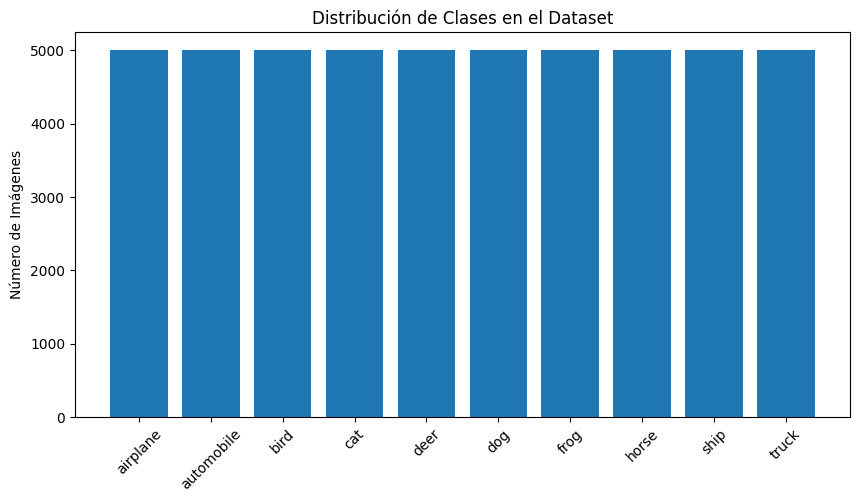

In [6]:
# Nueva celda - Análisis de distribución de clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizar distribución de clases
plt.figure(figsize=(10, 5))
plt.bar(class_names, [np.sum(y_train == i) for i in range(10)])
plt.title('Distribución de Clases en el Dataset')
plt.xticks(rotation=45)
plt.ylabel('Número de Imágenes')
plt.show()

In [7]:
# Calcular pesos de clases para datos desbalanceados
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

logging.info(f"Class weights computed: {class_weight_dict}")

In [8]:
# Preprocesamiento mejorado
def preprocess_data(x_train, x_test, y_train, y_test):
    # Normalización
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    
    # Normalización de contraste
    def normalize_contrast(image):
        mean = np.mean(image)
        std = np.std(image)
        return (image - mean) / (std + 1e-7)
    
    x_train = np.array([normalize_contrast(img) for img in x_train])
    x_test = np.array([normalize_contrast(img) for img in x_test])
    
    # One-hot encoding
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess_data(x_train, x_test, y_train, y_test)

In [9]:
# Data Augmentation mejorado
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2  # Para separar validación
)

datagen.fit(x_train)

2. **Model Architecture**
   - Design a CNN architecture suitable for image classification.
   - Include convolutional layers, pooling layers, and fully connected layers.

In [10]:
# Your code here :
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [11]:
def create_model(dropout_rate=0.3, filters_start=32, l2_reg=0.01):
    from tensorflow.keras.regularizers import l2
    
    model = Sequential([
        # Primer bloque
        Conv2D(filters_start, (3,3), padding='same', 
               activation='relu',
               kernel_regularizer=l2(l2_reg),
               input_shape=(32,32,3)),
        BatchNormalization(),
        Conv2D(filters_start, (3,3), padding='same', 
               activation='relu',
               kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(dropout_rate),
        
        # Segundo bloque
        Conv2D(filters_start*2, (3,3), padding='same', 
               activation='relu',
               kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Conv2D(filters_start*2, (3,3), padding='same', 
               activation='relu',
               kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(dropout_rate),
        
        # Tercer bloque
        Conv2D(filters_start*4, (3,3), padding='same', 
               activation='relu',
               kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Conv2D(filters_start*4, (3,3), padding='same', 
               activation='relu',
               kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(dropout_rate),
        
        # Clasificador
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    return model

In [12]:
# Grid Search para hiperparámetros
from sklearn.model_selection import ParameterGrid

param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [64, 128],
    'filters_start': [32, 64]
}

# Dividir datos
validation_split = 0.2
split_idx = int(len(x_train) * (1 - validation_split))
x_train_split = x_train[:split_idx]
y_train_split = y_train[:split_idx]
x_val = x_train[split_idx:]
y_val = y_train[split_idx:]

# Función de entrenamiento
def train_model_with_params(params):
    model = create_model(
        dropout_rate=params['dropout_rate'],
        filters_start=params['filters_start']
    )
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]
    
    history = model.fit(
        x_train_split, y_train_split,
        batch_size=params['batch_size'],
        epochs=50,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Ejecutar grid search
results = []
for params in ParameterGrid(param_grid):
    print(f"\nProbando parámetros: {params}")
    model, history = train_model_with_params(params)
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    results.append({
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'history': history.history
    })

# Encontrar mejores parámetros
best_result = max(results, key=lambda x: x['val_acc'])
print("\nMejores parámetros encontrados:")
print(f"Accuracy de validación: {best_result['val_acc']:.4f}")
print("Parámetros:", best_result['params'])


Probando parámetros: {'batch_size': 64, 'dropout_rate': 0.2, 'filters_start': 32, 'learning_rate': 0.001}


/opt/anaconda3/envs/tfgpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-19 13:38:26.913901: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-19 13:38:26.913922: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-19 13:38:26.913932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-19 13:38:26.913946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-19 13:38:26.913955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

Epoch 1/50


2024-12-19 13:38:27.998920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.3626 - loss: 6.9378 - val_accuracy: 0.5386 - val_loss: 2.1323 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.5930 - loss: 1.8211 - val_accuracy: 0.6389 - val_loss: 1.5022 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6396 - loss: 1.4870 - val_accuracy: 0.6418 - val_loss: 1.4994 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6492 - loss: 1.4940 - val_accuracy: 0.6691 - val_loss: 1.4250 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6636 - loss: 1.4676 - val_accuracy: 0.6887 - val_loss: 1.4055 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6617 - loss: 1.4751 - val_accuracy: 0.6453 - val_loss: 1.5322 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6709 - loss: 1.4563

3. **Model Training**
   - Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
   - Utilize techniques such as early stopping to prevent overfitting.

In [1]:
# Entrenamiento del modelo final con los mejores parámetros
best_params = best_result['params']
final_model = create_model(
    dropout_rate=best_params['dropout_rate'],
    filters_start=best_params['filters_start']
)

# Learning rate schedule personalizado
def cosine_decay_with_warmup(epoch, total_epochs=50, warmup_epochs=5):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs * best_params['learning_rate']
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return best_params['learning_rate'] * 0.5 * (1 + np.cos(np.pi * progress))

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(cosine_decay_with_warmup),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

final_history = final_model.fit(
    x_train, y_train,
    batch_size=best_params['batch_size'],
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Añadir pesos de clase
    verbose=1
)

# Registrar resultados del entrenamiento
logging.info(f"Training completed. Final validation accuracy: {final_history.history['val_accuracy'][-1]:.4f}")

NameError: name 'best_result' is not defined

4. **Model Evaluation**
   - Evaluate the trained model on a separate validation set.
   - Compute and report metrics such as accuracy, precision, recall, and F1-score.
   - Visualize the confusion matrix to understand model performance across different classes.

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

def evaluate_model_detailed(model, x_test, y_test):
    # Monitorear recursos durante la evaluación
    cpu, ram = monitor_resources()
    
    predictions = model.predict(x_test)
    
    # ROC AUC por clase
    roc_aucs = []
    for i in range(10):
        roc_auc = roc_auc_score(y_test[:, i], predictions[:, i])
        roc_aucs.append(roc_auc)
    
    results = {
        'roc_auc_mean': np.mean(roc_aucs),
        'roc_auc_per_class': dict(zip(class_names, roc_aucs)),
        'resource_usage': {
            'cpu_percent': cpu,
            'ram_percent': ram
        }
    }
    
    logging.info(f"Detailed evaluation results: {results}")
    return results

# Evaluar modelo final
detailed_results = evaluate_model_detailed(final_model, x_test, y_test)
print("\nResultados detallados de evaluación:")
print(f"ROC AUC promedio: {detailed_results['roc_auc_mean']:.4f}")
print("\nROC AUC por clase:")
for class_name, auc in detailed_results['roc_auc_per_class'].items():
    print(f"{class_name}: {auc:.4f}")

In [ ]:
# Visualización de resultados del entrenamiento
def plot_training_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Precisión del Modelo')
    ax1.set_ylabel('Precisión')
    ax1.set_xlabel('Época')
    ax1.legend(['Entrenamiento', 'Validación'])
    
    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Pérdida del Modelo')
    ax2.set_ylabel('Pérdida')
    ax2.set_xlabel('Época')
    ax2.legend(['Entrenamiento', 'Validación'])
    
    plt.tight_layout()
    plt.show()

plot_training_results(final_history)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

# Predicciones
predictions = final_model.predict(x_test)  # Usar final_model en lugar de model
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Verificar rangos
print("Rango de predicciones:", np.min(predictions_classes), "-", np.max(predictions_classes))
print("Rango de valores reales:", np.min(true_classes), "-", np.max(true_classes))

# Calcular y visualizar métricas
if (0 <= np.min(predictions_classes) <= 9) and (0 <= np.max(predictions_classes) <= 9):
    # Matriz de confusión con visualización mejorada
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predictions_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Métricas por clase
    print("\nMétricas por Clase:")
    for i, clase in enumerate(class_names):
        print(f"\nClase {clase}:")
        print(f"F1-Score: {f1_score(true_classes == i, predictions_classes == i):.4f}")
        print(f"Precisión: {precision_score(true_classes == i, predictions_classes == i):.4f}")
        print(f"Recall: {recall_score(true_classes == i, predictions_classes == i):.4f}")

    # Métricas globales
    print("\nMétricas Globales:")
    print(f"F1-Score: {f1_score(true_classes, predictions_classes, average='weighted'):.4f}")
    print(f"Precisión: {precision_score(true_classes, predictions_classes, average='weighted'):.4f}")
    print(f"Recall: {recall_score(true_classes, predictions_classes, average='weighted'):.4f}")
    
    # Visualizar ejemplos de predicciones incorrectas
    incorrect_mask = predictions_classes != true_classes
    incorrect_indices = np.where(incorrect_mask)[0]
    
    if len(incorrect_indices) > 0:
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(incorrect_indices[:5]):  # Mostrar primeros 5 errores
            plt.subplot(1, 5, i+1)
            plt.imshow(x_test[idx])
            plt.title(f'Real: {class_names[true_classes[idx]]}\nPred: {class_names[predictions_classes[idx]]}')
            plt.axis('off')
        plt.suptitle('Ejemplos de Predicciones Incorrectas')
        plt.show()
else:
    print("Error: Las predicciones no están en el rango esperado")

5. **Transfer Learning**
    - Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
        - You may find this [link](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) helpful.
        - [This](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) is the Pytorch version.
    - Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

def create_transfer_model():
    # Cargar ResNet50 pre-entrenado (mejor que VGG16 para este caso)
    base_model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(32, 32, 3))
    
    # Congelar capas base inicialmente
    for layer in base_model.layers:
        layer.trainable = False
    
    # Añadir capas personalizadas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Crear y compilar modelo
transfer_model = create_transfer_model()
transfer_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Entrenar primera fase
history_transfer = transfer_model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

# Fine-tuning
for layer in transfer_model.layers[-20:]:  # Descongelar últimas capas
    layer.trainable = True

transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_fine_tuning = transfer_model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

In [ ]:
# Ensemble de modelos
def create_ensemble_predictions(models, x_test):
    predictions = []
    for model in models:
        pred = model.predict(x_test)
        predictions.append(pred)
    
    # Promedio de predicciones
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

# Crear ensemble con los mejores modelos
ensemble_models = [
    final_model,  # Modelo CNN personalizado
    transfer_model  # Modelo con transfer learning
]

# Predicciones del ensemble
ensemble_predictions = create_ensemble_predictions(ensemble_models, x_test)
ensemble_classes = np.argmax(ensemble_predictions, axis=1)

# Evaluar ensemble
print("\nMétricas del Ensemble:")
print(f"F1-Score: {f1_score(true_classes, ensemble_classes, average='weighted'):.4f}")
print(f"Precisión: {precision_score(true_classes, ensemble_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(true_classes, ensemble_classes, average='weighted'):.4f}")

6. **Code Quality**
   - Well-structured and commented code.
   - Proper documentation of functions and processes.
   - Efficient use of libraries and resources.

6. **Report**
   - Write a concise report detailing the approach taken, including:
     - Description of the chosen CNN architecture.
     - Explanation of preprocessing steps.
     - Details of the training process (e.g., learning rate, batch size, number of epochs).
     - Results and analysis of models performance.
     - What is your best model. Why?
     - Insights gained from the experimentation process.
   - Include visualizations and diagrams where necessary.

7. **Model deployment**
     - Pick the best model 
     - Build an app using Flask - Can you host somewhere other than your laptop? **+5 Bonus points if you use [Tensorflow Serving](https://www.tensorflow.org/tfx/guide/serving)**
     - User should be able to upload one or multiples images get predictions including probabilities for each prediction

In [ ]:
# Guardar el mejor modelo (ensemble)
import joblib

# Guardar modelos individuales
final_model.save('cnn_model.h5')
transfer_model.save('transfer_model.h5')

# Guardar información del ensemble
ensemble_info = {
    'model_paths': ['cnn_model.h5', 'transfer_model.h5'],
    'class_names': class_names
}
joblib.dump(ensemble_info, 'ensemble_info.pkl')

# API Flask mejorada
from flask import Flask, request, jsonify, make_response
from PIL import Image
import io

app = Flask(__name__)

# Cargar modelos al inicio
def load_ensemble():
    ensemble_info = joblib.load('ensemble_info.pkl')
    models = [tf.keras.models.load_model(path) for path in ensemble_info['model_paths']]
    return models, ensemble_info['class_names']

ensemble_models, class_names = load_ensemble()

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Validar entrada
        if 'image' not in request.files:
            return make_response(jsonify({'error': 'No image file'}), 400)
        
        file = request.files['image']
        image = Image.open(io.BytesIO(file.read()))
        
        # Preprocesar imagen
        image = image.resize((32, 32))
        img_array = np.array(image) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predicción con ensemble
        predictions = create_ensemble_predictions(ensemble_models, img_array)
        class_idx = np.argmax(predictions[0])
        probabilities = predictions[0].tolist()
        
        return jsonify({
            'class_name': class_names[class_idx],
            'class_id': int(class_idx),
            'confidence': float(probabilities[class_idx]),
            'probabilities': {
                class_names[i]: float(prob) 
                for i, prob in enumerate(probabilities)
            }
        })
        
    except Exception as e:
        return make_response(jsonify({'error': str(e)}), 500)

if __name__ == '__main__':
    app.run(debug=True)